137711 / 202248
5.967944277454606e-19


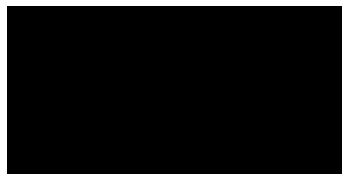

138946 / 202248
0.012889586246297989


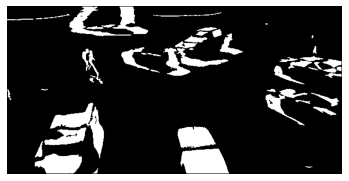

140188 / 202248
0.007644644748060568


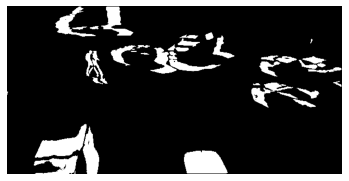

141140 / 202248
0.005780307751544401


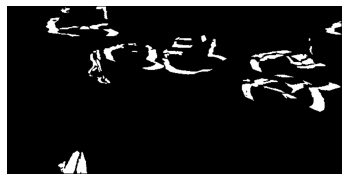

141956 / 202248
0.009384653996945781


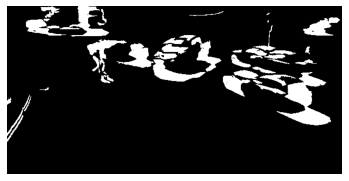

142418 / 202248
0.015435953952306755


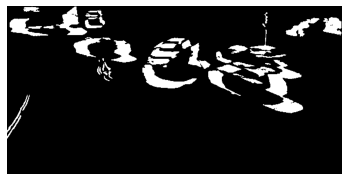

142945 / 202248
0.009243331767463264


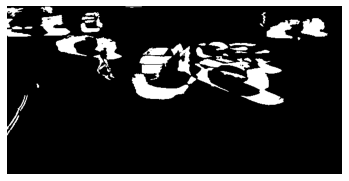

143190 / 202248
0.00802937576672519


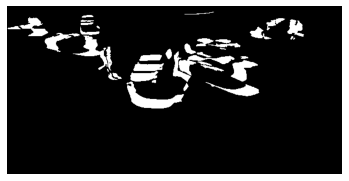

142681 / 202248
0.007711181867445128


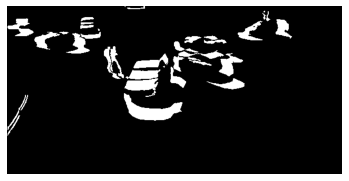

142082 / 202248
0.007232831730949599


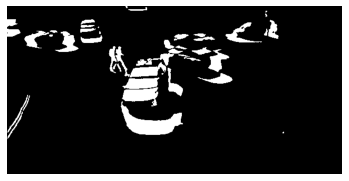

140818 / 202248
0.012284319486431992


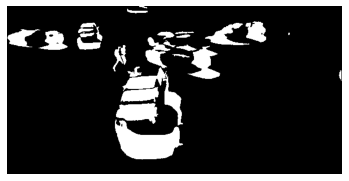

140253 / 202248
0.0060956541651357886


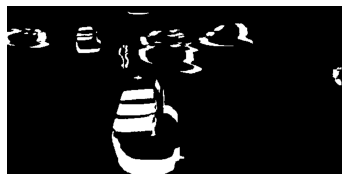

139496 / 202248
0.0038720242142535944


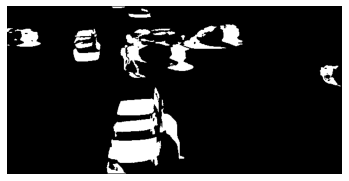

139767 / 202248
0.012538228429855509


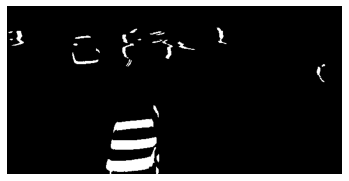

139742 / 202248
0.0038936341509506877


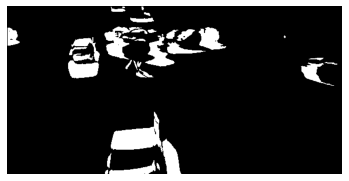

140206 / 202248
0.013250309750575026


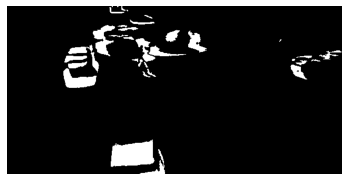

141896 / 202248
0.010732042287435234


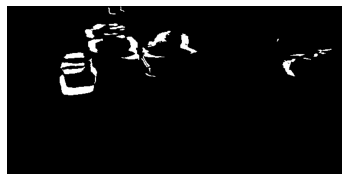

141096 / 202248
0.009955484034705295


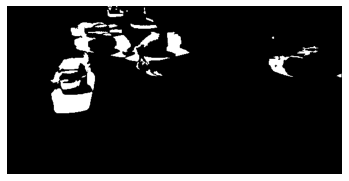

141127 / 202248
0.00875161367787131


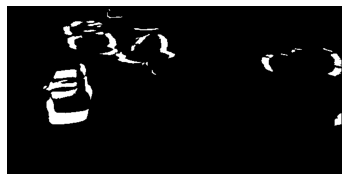

140701 / 202248
0.011229990131044167


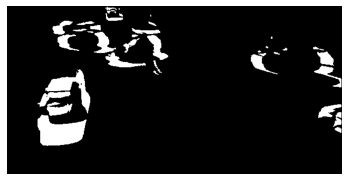

140095 / 202248
0.011025855209841999


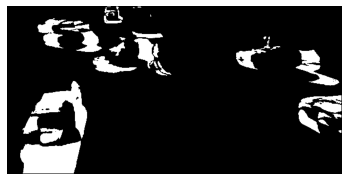

140072 / 202248
0.008516360352233496


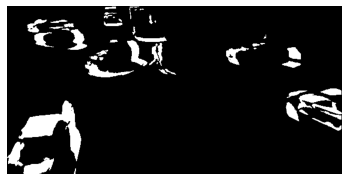

141475 / 202248
0.007494463012860224


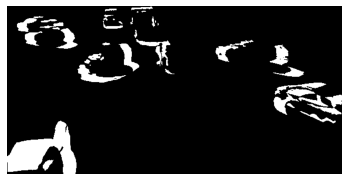

141815 / 202248
0.011844583817307366


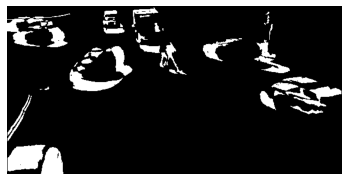

141914 / 202248
0.012099725829432608


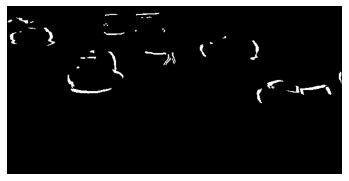

140855 / 202248
0.008657547445576593


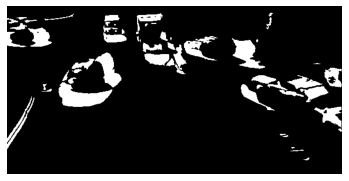

140251 / 202248
0.006011872821808108


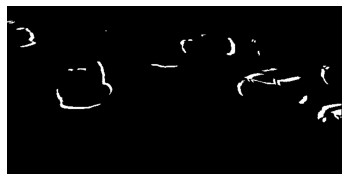

139919 / 202248
0.01077711912463837


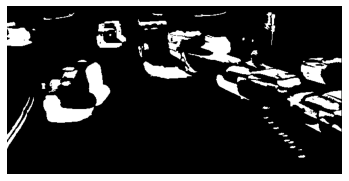

140720 / 202248
0.014043695183196694


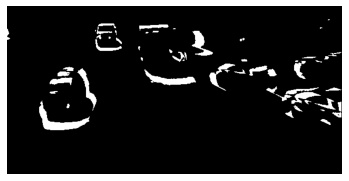

141028 / 202248
0.013116044284433416


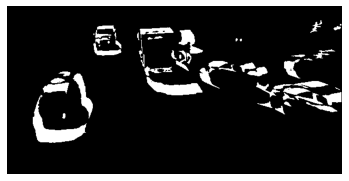

139995 / 202248
0.011856824714973777


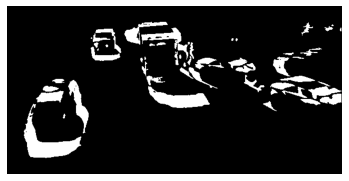

139218 / 202248
0.00751927892452027


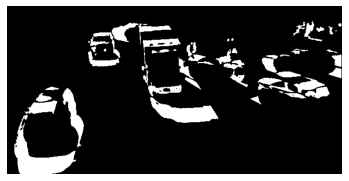

138856 / 202248
0.011549674599313184


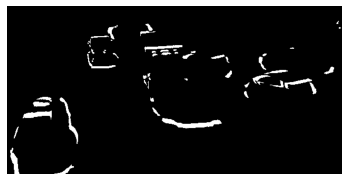

137467 / 202248
0.010166153822295701


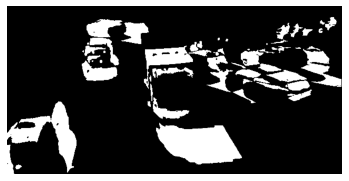

138733 / 202248
0.011401994971747927


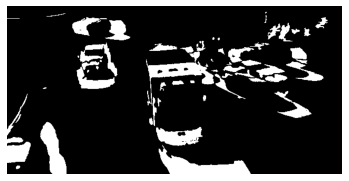

139618 / 202248
0.016310018336665483


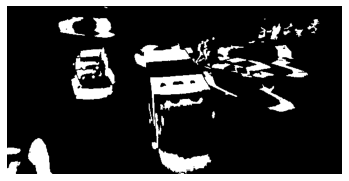

139369 / 202248
0.016528940252931484


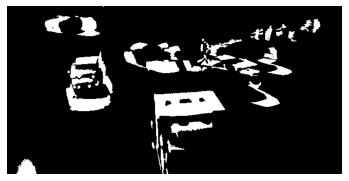

138666 / 202248
0.01945633172131026


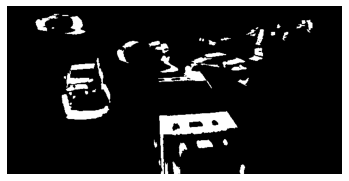

141128 / 202248
0.012566576983827264


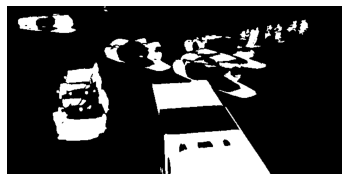

140284 / 202248
0.01855814676028768


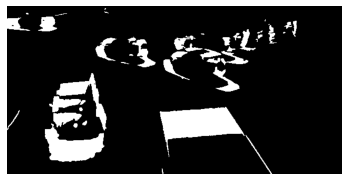

141293 / 202248
0.007977362246587183


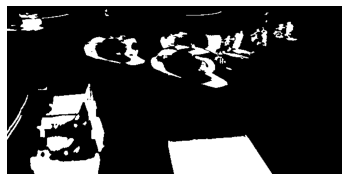

140883 / 202248
0.012989797953736646


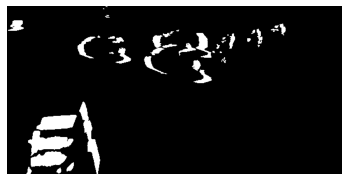

141650 / 202248
0.012579476041200454


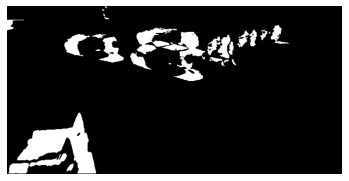

142120 / 202248
0.016437520653945555


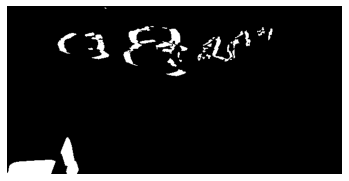

142562 / 202248
0.01457456709961227


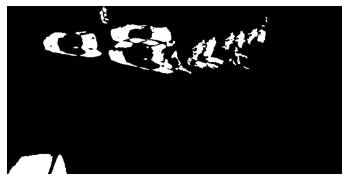

142384 / 202248
0.018324996896179162


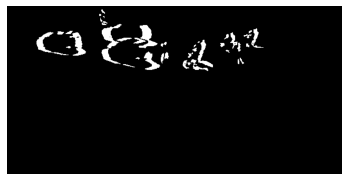

142583 / 202248
0.01573576520258211


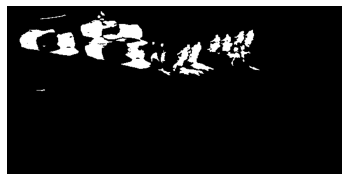

143023 / 202248
0.018050221971716986


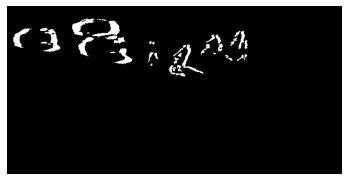

143811 / 202248
0.015196719966942248


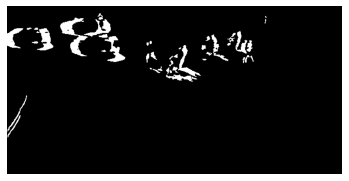

143714 / 202248
0.014503777624285933


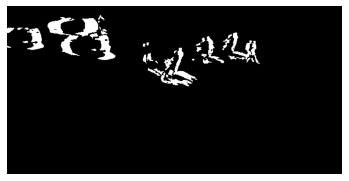

9.067687741915385


In [1]:
# %load run_motion.py
import os
import numpy as np
import cv2
from scipy.interpolate import RectBivariateSpline
from skimage.filters import apply_hysteresis_threshold
import time
from matplotlib import pyplot as plt


def lucas_kanade_affine(img1, img2, p, Gx, Gy):
    ### START CODE HERE ###
    temp = img1.copy()
    img  = img2.copy()/255.0
    Gx_ = Gx.copy()/255.0
    Gy_ = Gy.copy()/255.0

    height, width = temp.shape
    x = np.arange(0,width,1)
    y = np.arange(0,height,1)
    img_spline = RectBivariateSpline(y, x, img)
    Gx_spline  = RectBivariateSpline(y, x, Gx_)
    Gy_spline  = RectBivariateSpline(y, x, Gy_)
    gxmean = np.mean(np.abs(Gx))
    gymean = np.mean(np.abs(Gy))
    
    H = np.zeros((6,6))
    error_sum = np.zeros((6,1))
    count = 0
    total = len(x)*len(y)
    for y_ in y:
        for x_ in x:
            wx = (1 + p[0,0])*x_ + p[2,0]*y_ + p[4,0]
            wy = p[1,0]*x_ + (1 + p[3,0])*y_ + p[5,0]
            if (wx >= 0 and wy >= 0 and wx <= width-1 and wy <= height-1):
                gx = float(Gx_spline.ev(wy,wx)*255.0)
                gy = float(Gy_spline.ev(wy,wx)*255.0)
                if (abs(gx) < gxmean and abs(gy) < gymean): 
                    count += 1
                    continue
                value = float(img_spline.ev(wy,wx)*255.0)
                if (value < 0 or value > 255):
                    continue
                error = temp[y_,x_] - value
                grad = np.array([[gx*x_],
                                 [gy*x_],
                                 [gx*y_],
                                 [gy*y_],
                                 [gx],
                                 [gy]])
                error_sum = error_sum + grad*error
                H = H + grad@grad.T
    print(count,"/",total)
    inv_H = np.linalg.pinv(H)
    dp = inv_H@error_sum    
    ### END CODE HERE ###
    return dp

def subtract_dominant_motion(img1, img2):
    Gx = cv2.Sobel(I, cv2.CV_64F, 1, 0, ksize = 5) # do not modify this
    Gy = cv2.Sobel(I, cv2.CV_64F, 0, 1, ksize = 5) # do not modify this
    th_hi = 0.4*256 # you can modify this
    th_lo = 0.25*256 # you can modify this

    ### START CODE HERE ###
    P = np.zeros((6,1))
    
    temp = img1.copy()
    img  = img2.copy()
    dp = lucas_kanade_affine(temp, img, P, Gx, Gy)
    P = dp
    first = np.linalg.norm(dp)
    print(first)

    height, width = img.shape
    x = np.arange(0,width,1)
    y = np.arange(0,height,1)
    temp_norm = temp/255.0
    temp_spline = RectBivariateSpline(y, x, temp_norm)
    
    moving_image = np.zeros(img.shape)
    for y_ in y:
        for x_ in x:
            wx = ((x_-P[4,0])*(1+P[3,0])-(y_-P[5,0])*P[2,0])/(-P[1,0]*P[2,0]+(1+P[0,0])*(1+P[3,0]))
            wy = ((x_-P[4,0])*P[1,0]-(y_-P[5,0])*(1+P[0,0]))/(P[1,0]*P[2,0]-(1+P[0,0])*(1+P[3,0]))
            if (wx >= 0 and wy >= 0 and wx <= width-1 and wy <= height-1):
                value = float(temp_spline.ev(wy,wx)*255)
                if (value >= 0 and value <= 255):
                    moving_image[y_][x_] = abs(img[y_][x_] - value)
    
    ### END CODE HERE ###
    hyst = apply_hysteresis_threshold(moving_image, th_lo, th_hi)
    plt.figure()
    plt.imshow(hyst,cmap='gray')
    plt.axis('off')
    plt.show()
    return hyst

if __name__ == "__main__":
    start = time.time()
    data_dir = 'data'
    video_path = 'motion.mp4'
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(video_path, fourcc, 150/20, (636, 318))
    tmp_path = os.path.join(data_dir, "organized-{}.jpg".format(0))
    T = cv2.cvtColor(cv2.imread(tmp_path), cv2.COLOR_BGR2GRAY)
    for i in range(0, 50):
        img_path = os.path.join(data_dir, "organized-{}.jpg".format(i))
        I = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2GRAY)
        clone = I.copy()
        moving_img = subtract_dominant_motion(T, I)
        clone = cv2.cvtColor(clone, cv2.COLOR_GRAY2BGR)
        clone[moving_img, 2] = 522
        out.write(clone)
        T = I
    out.release()
    print((time.time()-start)/60)
    